# Capstone: Airbnb Price Listing Prediction
## Part 3 Feature Engineering & Model Benchmark

_Authors: Evonne Tham_

In this notebook, the goal will be to use the insights garnered from EDA to create a feature-selected and finetuned model that will perform well on generalized, unseen data.

But before that model preparation will be carried out by one-hot encoding and producing dummy variables for categorical features, after which, I will go through the modelling process as per below:

- Split the data into train, test, and validation.
- Train as many models as there are hyperparameter combinations on the train set.
- Evaluate each of these models on the validation set.

Workflow source: https://github.com/esentri/datascience_blog_resources/blob/master/model_selection.ipynb


## Contents of this notebook
- [1. Import Necessary Libraries and Load Data](#1.-Import-Necessary-Libraries-and-Load-Data)
- [2. Feature Engineering](#2.-Feature-Engineering)
    - [2.1. Distance](#2.1.-Distance)
    - [2.2. Categorical Variables](#2.2.-Categorical-Variables)
    - [2.3.Amenities](#2.3.-Amenities)
- [3. Model Prep](#3.-Model-Prep) 
- [4. Modelling](#4.-Modelling)


## 1. Import Necessary Libraries and Load Data 

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Please also type in the following command line/terminal installations for this notebook**:

- `brew install libomp`
- `pip install xgboost`
- `pip install geopy`

In [2]:
# Load in Data 
df = pd.read_csv('../datasets/final_df.csv')

#Set id as index 
df.set_index('id', inplace=True)

print(f"Total Number of Listing: {df.shape[0]} | Total Number of Features: {df.shape[1]}")
df.head(4).T

Total Number of Listing: 13206 | Total Number of Features: 43


id,35303,197677,289597,370759
host_id,151977,964081,341577,1573631
host_since,2010-06-25,2011-08-13,2011-01-10,2012-01-06
host_response_time,unknown,within a few hours,within a few hours,within a day
host_response_rate,unknown,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%
host_is_superhost,0,1,0,1
host_listings_count,3,1,2,3
host_identity_verified,1,1,1,1
neighbourhood,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku
country_code,JP,JP,JP,JP


---
<a id=’feature_engineering’></a>
## 2. Feature Engineering 

##### 2.1. Distance

Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called center of Tokyo instead of just relying on the neighbourhoods or areas. I will also be picking the centre of some popular hotspots such as, Shinjuku, Toshima, and Taito, where most listings are clustered at. Additionally, I will be looking at the distance of listing away from airport, Narita, and Hanida.

Here, I will be using Geopy as it can calculate geodesic distance between two points using the great-circle distance which uses a spherical model of the earth. 

In [3]:
def distance_to(from_lat, from_lon, to_lat, to_lon):
    to = (to_lat, to_lon)
    accommodation = (from_lat, from_lon)
    return great_circle(to, accommodation).km

In [4]:
tokyo_center = (35.652832, 139.839478)
shinjuku_center = (35.6938, 139.7034)
toshima_center = (35.7263, 139.7168)
taito_center = (35.7126, 139.7802)
narita_airport = (35.7720, 140.3929)
hanida_airport = (35.5494, 139.7798)

df['tokyo_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *tokyo_center), axis=1)
df['shinjuku_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *shinjuku_center), axis=1)
df['toshima_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *toshima_center), axis=1)
df['taito_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *taito_center), axis=1)
df['narita_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *narita_airport), axis=1)
df['hanida_dist'] = df.apply(lambda x: distance_to(x.latitude, x.longitude, *hanida_airport), axis=1)

##### 2.2. Categorical Variables

Categorical variables will be converted here into a form that could be provided to ML algorithms to do a better job in prediction through one-hot encoding. Furthermore the column containing Amenities will be separated via get dummies as well. 

In [5]:
df_dummies = pd.get_dummies(df, columns=['property_type',
                                         'room_type',
                                         'cancellation_policy',
                                         'host_response_time',
                                         'host_acceptance_rate',
                                         'review_scores_rating',
                                         'review_scores_accuracy',
                                         'review_scores_cleanliness',
                                         'review_scores_checkin',
                                         'review_scores_communication',
                                         'review_scores_location',
                                         'review_scores_value',
                                         'instant_bookable',
                                         'is_location_exact'
                                ], 
                         drop_first = False)

##### 2.3. Amenities

Some amenities are more important than others (i.e. a balcony is more likely to increase price than a hair dryer), and some are likely to be fairly uncommon (i.e.. 'waterfront'). For the purpose of this project, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the feature importance section. If it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

In [6]:
# Split amenities string into column
all_amenities = df_dummies['amenities'].str.get_dummies(sep=',')
print(f"Total Types of Amenities: {all_amenities.shape[1]}")

Total Types of Amenities: 154


In [7]:
# Grouping similar amenities together
df_dummies["24_hour_checkin"] = (all_amenities["24-hour check-in"])

df_dummies["air_conditioning"] = (all_amenities["air conditioning"])

df_dummies["entertainment"] = (all_amenities["cable tv"] + 
                               all_amenities["carbon monoxide alarm"] + 
                               all_amenities["dvd player"] + 
                               all_amenities["game console"] + 
                               all_amenities["netflix"] + 
                               all_amenities["projector and screen"] + 
                               all_amenities["smart tv"] + 
                               all_amenities["tv"])

df_dummies["bbq"] = (all_amenities["barbecue utensils"] + 
                     all_amenities["bbq grill"])

df_dummies["balcony"] = (all_amenities["balcony"] + 
                         all_amenities["patio or balcony"])

df_dummies["nature_and_views"] = (all_amenities["beachfront"] + 
                                  all_amenities["garden or backyard"] + 
                                  all_amenities["lake access"] + 
                                  all_amenities["waterfront"])

df_dummies["bedroom_essentials"] = (all_amenities["bed linens"] + 
                                    all_amenities["bedroom comforts"] + 
                                    all_amenities["extra pillows and blankets"] + 
                                    all_amenities["firm mattress"] + 
                                    all_amenities["memory foam mattress"] + 
                                    all_amenities["room-darkening shades"])

df_dummies["bathroom_amenities"] = (all_amenities[" toilet"] + 
                                    all_amenities["handheld shower head"] + 
                                    all_amenities["heated towel rack"] + 
                                    all_amenities["hot water"])

df_dummies["toiletties"] = (all_amenities["bath towel"] + 
                            all_amenities["bathroom essentials"] + 
                            all_amenities["body soap"] + 
                            all_amenities["essentials"] + 
                            all_amenities["shampoo"] + 
                            all_amenities["shower gel"] + 
                            all_amenities["toilet paper"])

df_dummies["essentials_amenities"] = (all_amenities["bottled water"] + 
                                      all_amenities["first aid kit"] + 
                                      all_amenities["slippers"] + 
                                      all_amenities["trash can"])

df_dummies["breakfast"] = (all_amenities["bread maker"] + 
                           all_amenities["breakfast"])

df_dummies["coffee"] = (all_amenities["coffee maker"])

df_dummies["kitchen_amenities"] = (all_amenities["baking sheet"] + 
                                   all_amenities["convection oven"] + 
                                   all_amenities["cooking basics"] + 
                                   all_amenities["dishes and silverware"] + 
                                   all_amenities["full kitchen"] + 
                                   all_amenities["gas oven"] + 
                                   all_amenities["hot water kettle"] + 
                                   all_amenities["kitchen"] + 
                                   all_amenities["kitchenette"] + 
                                   all_amenities["microwave"] + 
                                   all_amenities["oven"] + 
                                   all_amenities["refrigerator"] +
                                   all_amenities["stove"])

df_dummies["white_goods"] = (all_amenities["dishwasher"] + 
                             all_amenities["dryer"])

df_dummies["elevator"] = (all_amenities["elevator"])

df_dummies["gym"] = (all_amenities["gym"])

df_dummies["child_friendly"] = (all_amenities["baby bath"] + 
                                all_amenities["baby monitor"] + 
                                all_amenities["babysitter recommendations"] + 
                                all_amenities["changing table"] + 
                                all_amenities["children’s books and toys"] + 
                                all_amenities["children’s dinnerware"] + 
                                all_amenities["crib"] + 
                                all_amenities["family/kid friendly"] + 
                                all_amenities["high chair"] + 
                                all_amenities["pack ’n play/travel crib"] + 
                                all_amenities["table corner guards"])


df_dummies["tubs_and_pools"] = (all_amenities["bathtub"] + 
                                all_amenities["bathtub with bath chair"] + 
                                all_amenities["hot tub"] + 
                                all_amenities["pool"] + 
                                all_amenities["pool with pool hoist"] + 
                                all_amenities["soaking tub"])

df_dummies["internet"] = (all_amenities["ethernet connection"] + 
                          all_amenities["internet"] + 
                          all_amenities["pocket wifi"] + 
                          all_amenities["wifi"])

df_dummies["long_term_stays"] = (all_amenities["long term stays allowed"])

df_dummies["pets_friendly"] = (all_amenities["cat(s)"] + 
                               all_amenities["dog(s)"] + 
                               all_amenities["other pet(s)"] + 
                               all_amenities["pets allowed"] + 
                               all_amenities["pets live on this property"])

df_dummies["safe_and_security"] = (all_amenities["fire extinguisher"] + 
                                   all_amenities["lock on bedroom door"] + 
                                   all_amenities["lockbox"] + 
                                   all_amenities["safety card"] + 
                                   all_amenities["smoke alarm"] + 
                                   all_amenities["smart lock"])

df_dummies["self_check_in"] = (all_amenities["self check-in"])

df_dummies["smoking_allowed"] = (all_amenities["smoking allowed"])

df_dummies["accessibility"] = (all_amenities["disabled parking spot"] + 
                               all_amenities["fixed grab bars for shower"] + 
                               all_amenities["fixed grab bars for toilet"] +
                               all_amenities["no stairs or steps to enter"] + 
                               all_amenities["roll-in shower"] + 
                               all_amenities["roll-in shower with chair"] + 
                               all_amenities["wheelchair accessible"])

df_dummies["parking_spaaces"] = (all_amenities["free parking on premises"] + 
                                 all_amenities["free street parking"]+ 
                                 all_amenities["paid parking off premises"] + 
                                 all_amenities["paid parking on premises"])

df_dummies["hospitality_services"] = (all_amenities["building staff"] + 
                                      all_amenities["doorman"] + 
                                      all_amenities["luggage dropoff allowed"] + 
                                      all_amenities["host greets you"])

df_dummies["laptop-friendly workspace"] = (all_amenities["laptop-friendly workspace"])


df_dummies["heating_amenities"] = (all_amenities["heated floors"] + 
                                   all_amenities["heating"])


df_dummies["other_electronics"] = (all_amenities["iron"] + 
                                   all_amenities["hair dryer"] + 
                                   all_amenities["air purifier"])


df_dummies["suitable for events"] = (all_amenities["suitable for events"])

df_dummies.shape

(13206, 134)

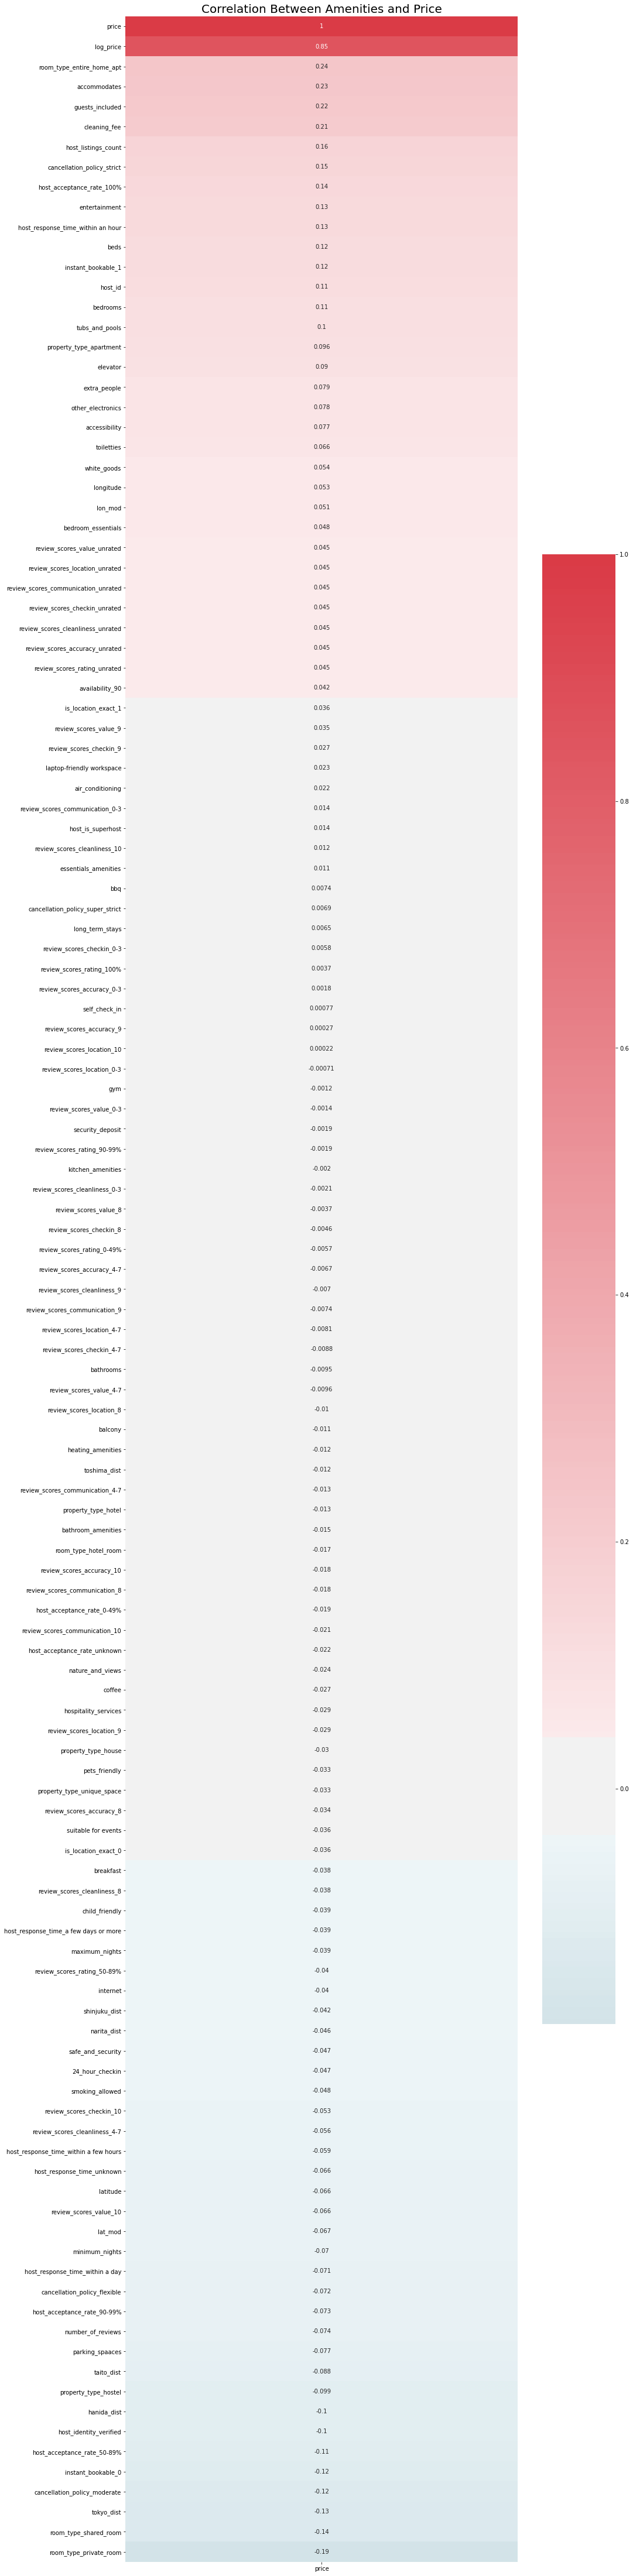

In [8]:
fig = plt.figure(figsize=(15,80))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr()

sns.heatmap(df_dummies.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True,
            cbar_kws={"shrink": .9},)

plt.title('Correlation Between Amenities and Price', fontsize=20);

So far, after encoding the various variables with numerical data, the heatmap shows a good range of variables and their respective correlation. There appears to be a few slightly significant variables such as `room_type_entire_room_apt`,`accomodates`,`guests_included`, `cleaning_fee` and `rome_type_private_room`. This is good for the modelling, as it would be useful to find out variables that may negatively affect Sale Price.


In [9]:
# Save df with dummies set
df_dummies.to_csv('../datasets/df_dummies.csv')

---
##  3. Model Prep

In [10]:
# Split Dataset into train and test set
train, test = train_test_split(df_dummies, test_size=0.2, random_state = 42)

In [11]:
# Save test set for production model
test.to_csv('../datasets/test.csv')

### i. Create X and y variables

In [12]:
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price'
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

###  ii. Baseline Prediction 

In [13]:
print(f'The mean value of the target vector is: {np.mean(y)}.')

The mean value of the target vector is: 18514.791650889816.


Without any regression modelling, the predicted value for every data point is 18440¥.

### iii. Train/ Validation Splits

In [14]:
# Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

### iv. Baseline score

In [15]:
dummy_constant = DummyRegressor(strategy='constant', constant = 17990.367118495848 )
dummy_constant.fit(X_train, y_train)
print(f'R2 score for baseline model: {dummy_constant.score(X_train, y_train)}.')

R2 score for baseline model: -0.0008265808689627008.


This is a bad $R^2$ score as it indicates that the baseline model explains basically none of the variability of the response data around its mean.

---
## 4. Modelling

This function will return the the train accuracy score, validation accuracy score, grid search score, best paramaters, $R^2$ score, MSE and RMSE which will then use this to evaluate our metrics against the validation set.

The 4 models that I will be using in this regression problem are:

- Linear Regression
    - The most basic form, where the model is not penalized for its choice of weights [[1]](https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29)
- ElasticNet
    - The hybrid of Lasso and Ridge, where both the absolute value penalization and squared penalization are included, being regulated with another coefficient l1_ratio [[1]](https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29)
- Support Vector Machine Regressor
    - It uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal boundary between the possible outputs. [[2]](https://community.alteryx.com/t5/Data-Science/Why-use-SVM/ba-p/138440#:~:text=SVM%20is%20a%20supervised%20machine,boundary%20between%20the%20possible%20outputs.)
- XGBoosting Classifier 
    - A scalable and accurate implementation of gradient boosting machines and it has proven to push the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed. [[2]](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html#:~:text=XGBoost%20is%20a%20scalable%20and,model%20performance%20and%20computational%20speed.)


On top of that RobustScaler will be used to standardize the data's scaling. This is because there is a fair number of outliers in the distributions that were already explored in the EDA notebook. Robust Scaler is so named because it handles outliers better.

In [16]:
# Scale the data
rs = RobustScaler()
rs.fit(X_train)
X_train_rs = rs.transform(X_train)
X_val_rs = rs.transform(X_val)

# Model instantiation
lr = LinearRegression()
enet = ElasticNetCV()
svr = SVR()
xgb = XGBRegressor()

# Run the different models and compare
lr_model = lr.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(lr, X_train_rs, y_train, cv=5).mean()))
print("LR score on training set with default parameters: {}". format(lr_model.score(X_train_rs, y_train)))
print("LR score on validation set with default parameters: {}". format(lr_model.score(X_val_rs, y_val)))
print("==============================================================================")

enet_model = enet.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(enet, X_train_rs, y_train, cv=5).mean()))
print("ENET score on training set with default parameters: {}". format(enet_model.score(X_train_rs, y_train)))
print("ENET score on validation set with default parameters: {}". format(enet_model.score(X_val_rs, y_val)))
print("==============================================================================")

svr_model = svr.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(svr, X_train_rs, y_train, cv=5).mean()))
print("SVR score on training set with default parameters: {}". format(svr_model.score(X_train_rs, y_train)))
print("SVR score on validation set with default parameters: {}". format(svr_model.score(X_val_rs, y_val)))
print("==============================================================================")

xgb_model = xgb.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(xgb, X_train_rs, y_train, cv=5).mean()))
print("XGBoost score on training set with default parameters: {}". format(xgb_model.score(X_train_rs, y_train)))
print("XGBoost score on validation set with default parameters: {}". format(xgb_model.score(X_val_rs, y_val)))

Accuracy of Model with Cross-Validation: 0.24489436987815463
LR score on training set with default parameters: 0.2663057151184013
LR score on validation set with default parameters: 0.22152756579130584
Accuracy of Model with Cross-Validation: 0.04408194787296238
ENET score on training set with default parameters: 0.045152940897706606
ENET score on validation set with default parameters: 0.04200475015766569
Accuracy of Model with Cross-Validation: -0.10800161063281251
SVR score on training set with default parameters: -0.10419332369267087
SVR score on validation set with default parameters: -0.09671613946043256
Accuracy of Model with Cross-Validation: 0.7451516378310372
XGBoost score on training set with default parameters: 0.9686038237945614
XGBoost score on validation set with default parameters: 0.7602413266886231


By comparing these models, 3 out of 4 performed pretty badly, especially for linear regression which performed the worst which is as expected. However, what is not expected is that XGBoost performed oddly well here. Nevertheless, lets see how much we can improve with hyperparameter tuning

##### Save Final Dataframe

In [17]:
train.to_csv('../datasets/train.csv')

----> Proceed to the next notebook for [Model Tuning](./04_Model_Tuning.ipynb)